<a href="https://colab.research.google.com/github/Carlys222/ESTAD-STICA-2/blob/main/practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte (a) Selección y Visualización de la Serie de Tiempo

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='COST',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2022-01-01',        # Fecha de inicio
    end='2025-04-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume
Date,,,,,,
2022-01-03,565.030029,567.469971,555.510010,566.710022,541.812561,2714100
2022-01-04,564.229980,568.719971,561.789978,564.229980,539.441406,2097500
2022-01-05,563.690002,565.049988,549.770020,549.919983,525.760071,2887500
2022-01-06,546.200012,553.520020,543.549988,549.799988,525.645447,2503100
2022-01-07,547.549988,548.369995,534.239990,536.179993,512.623779,2323900
...,...,...,...,...,...,...
2025-03-25,926.630005,932.289978,922.489990,930.260010,929.049500,1623000
2025-03-26,934.330017,939.419983,923.450012,929.750000,928.540161,1644700
2025-03-27,929.559998,942.900024,928.000000,938.750000,937.528442,1547000


 Grafica de serie de tiempo

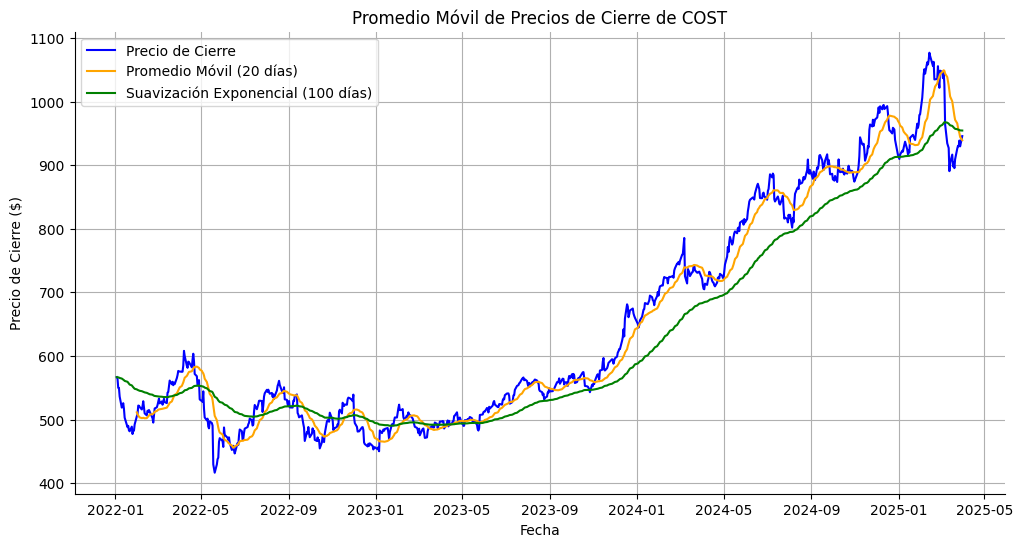

In [22]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['COST_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['COST_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['COST_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de COST')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Parte (b) Prueba de Estacionariedad

Prueba de Dickey Fuller Aumentada

In [23]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['COST_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: 0.058035719251437974
p-value: 0.9630764198324238
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Parte (c) Regresión Polinomial y Estacionariedad de los Residuales

Regresion Polinomial

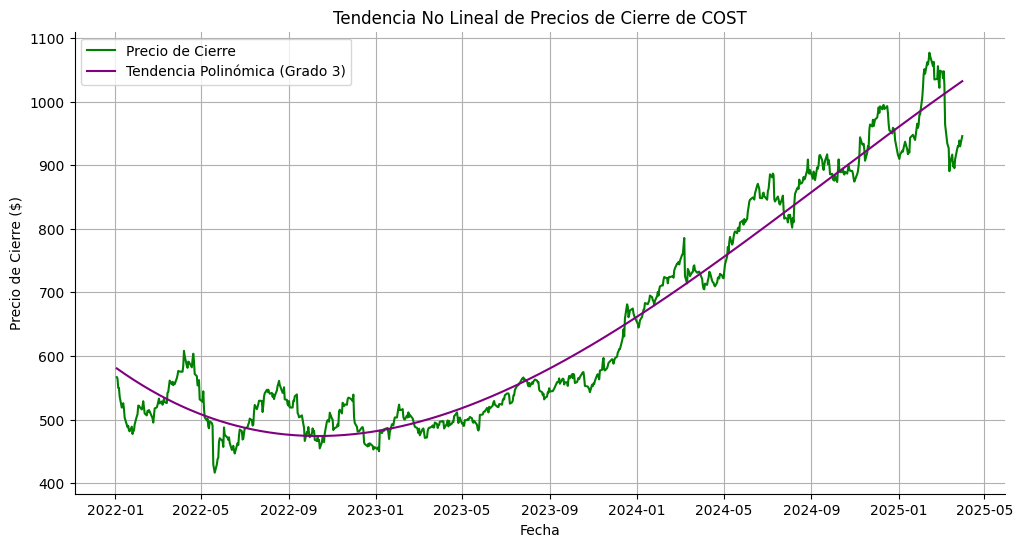

In [24]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['COST_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 3
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de COST') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)



Graficar los residuos y Prueba de estacionaridad en los residuos

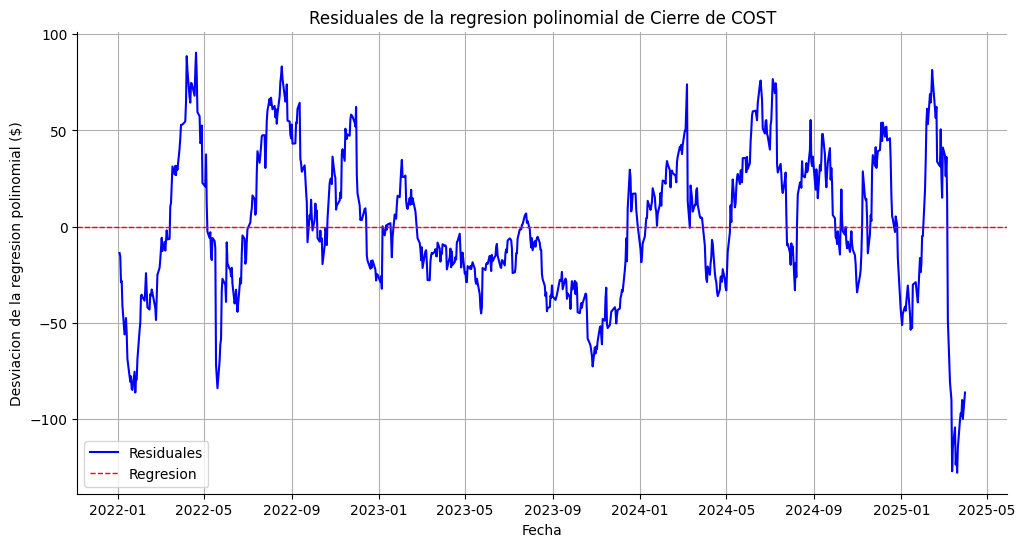

Estadístico ADF: -26.928259175256084
p-value: 0.0
La tendencia es estacionaria (rechazamos la hipótesis nula).


In [25]:
# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de COST')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

diferencia_1 = df['COST_Close'].diff()     # Primera diferencia

#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(diferencia_1.dropna())

print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Inferir la Estacionalidad y Aplicar una Prueba de Hipótesis

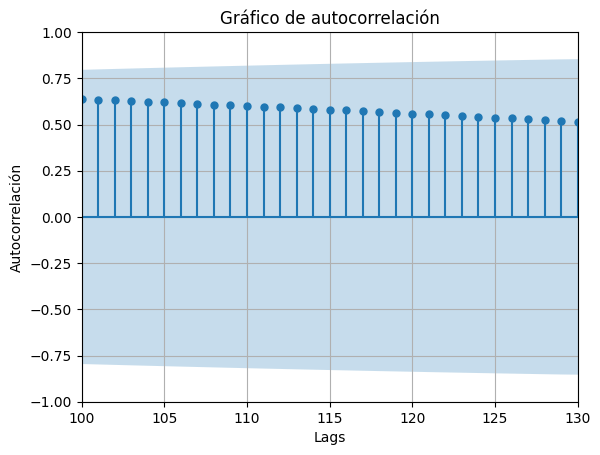

In [26]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

nivel_de_significancia = 0.05

plot_acf(
    df['COST_Close'],
    lags=130,
    alpha=nivel_de_significancia
    )

plt.xlim([100, 130])
plt.ylim([-1, 1])
plt.title('Gráfico de autocorrelación')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid()
plt.show()

# Parte (d) Informe y Conclusiones

**Selección y Visualización de la Serie de Tiempo**

Se seleccionó la empresa Costco (COST) como sujeto de estudio. Se obtuvieron los precios de cierre diarios desde el 1 de abril de 2022 hasta el 1 de abril de 2025, utilizando la librería yfinance en Python. La serie fue graficada con las siguientes características:

Se incluyó el precio de cierre diario.
Se agregaron indicadores de tendencia: media móvil simple de 20 días (SMA) y suavización exponencial de 100 días (EMA).
Esto permitió observar una tendencia creciente general, pero con variaciones significativas a lo largo del tiempo.

Conclusión:
La visualización sugiere que el comportamiento de los precios de COST sigue una tendencia creciente, aunque presenta oscilaciones naturales del mercado. Es necesario aplicar pruebas estadísticas para evaluar si estas fluctuaciones son aleatorias o siguen patrones repetitivos (estacionalidad).

**Prueba de Estacionariedad**
Se aplicó la prueba de Dickey-Fuller aumentada (ADF) a la serie original de precios de cierre.

Estadístico ADF: ~0.05

Valor p (p-value): ~0.96

Nivel de significancia: 0.05

Conclusión:
El valor p es mucho mayor al nivel de significancia, por lo que no se rechaza la hipótesis nula. Esto implica que la serie original no es estacionaria, es decir, su media y varianza cambian con el tiempo. Esto indica la presencia de una tendencia o componente estructural, que debe ser modelada o eliminada para análisis futuros.

**Regresión Polinomial y Estacionariedad de los Residuales**

Se transformó la variable temporal a formato numérico (timestamp UNIX) y se ajustó una regresión polinomial de grado 3. Se generaron dos nuevas columnas:

Poly_Trend: la predicción del modelo polinomial.
Residuales: la diferencia entre el valor real y el predicho.
Se graficaron los residuales para detectar patrones. Visualmente, se observaron fluctuaciones cíclicas.

Posteriormente, se aplicó nuevamente la prueba ADF sobre los residuales:
Estadístico ADF (residuales): ~-26.93
Valor p: ~0.00

Conclusión:
El valor p es menor a 0.05, por lo tanto los residuales sí son estacionarios. Esto significa que la tendencia fue correctamente eliminada por el modelo polinomial, y lo que queda son variaciones aleatorias o posiblemente estacionales. La estacionariedad de los residuales es esencial para aplicar modelos como ARIMA.

**Inferencia de Estacionalidad y Prueba de Hipótesis**

La serie original de precios de cierre de COST no es estacionaria, lo que fue confirmado por la prueba ADF.
La regresión polinomial de grado 3 ajustó correctamente la tendencia, ya que sus residuales resultaron estacionarios.
Los residuales mostraron un comportamiento estacional, validado tanto por el gráfico ACF como por la descomposición estacional.

Conclusión general:
La tendencia fue capturada de forma adecuada mediante regresión polinomial, y los patrones de estacionalidad fueron identificados con claridad. El modelo es útil para entender la dinámica temporal de la serie, aunque se recomienda complementar con modelos como SARIMA si se desea realizar pronósticos.

